<a href="https://colab.research.google.com/github/bcsrn/SlamSpam/blob/master/SlamSpam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#*Loading data*

---



In [0]:
from google.colab import drive
import numpy as np
import os
import pandas as pd


In [2]:
#mounting the google drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = '/content/gdrive/My Drive/IR/Project/Data'

In [0]:
## reading the data
import pandas as pd 
import gzip 

def parse(path):  
  g = gzip.open(path, 'rb') 
  for l in g: 
    yield eval(l) 
    
def getDF(path): 
  i = 0 
  df = {} 
  for d in parse(path): 
    df[i] = d 
    i += 1 
  return pd.DataFrame.from_dict(df, orient='index') 
    
df = getDF(path + '/Reviews_Electronics.json.gz')


In [5]:
#getting subset of dataset - focussed on 2 products
#asin - product number
df_1 = df.loc[df['asin'] == 'B007WTAJTO']
df_2 = df.loc[df['asin'] == 'B0019EHU8G']
df_new = df_1.append(df_2)
print(df_new.shape)
uniq_users = np.unique(df_new['reviewerID'])
print(len(uniq_users))
uniq_asins = np.unique(df_new['asin'])
print(len(uniq_asins))

(8350, 9)
8240
2


#* Labeling Data*

---



## TF-IDF on reviewText and Summary 

In [8]:
#Tfidf on reviewText column
from sklearn.feature_extraction.text import TfidfVectorizer

textvector = list(df_new["reviewText"])

print("Length of tectvector:", len(textvector))

vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 3)
X = vectorizer.fit_transform(textvector)
  


Length of tectvector: 8350


In [0]:
#tfidf on the summary column
from sklearn.feature_extraction.text import TfidfVectorizer

summary_vector = list(df_new["summary"])

vectorizer_s = TfidfVectorizer(stop_words = 'english', min_df = 3)
S = vectorizer_s.fit_transform(summary_vector)
  

In [10]:
S.shape

(8350, 724)

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

cosine = cosine_similarity(X)


## Review Centric Features

### Feature - 7 : Duplicate reviews from different users


In [12]:
### Feature - 7 : Duplicate reviews from different users
threshold = 0.9
list_sim = {}
for i,row in enumerate(cosine):
  for j, element in enumerate(row):
    if element >= threshold and i!=j:
      reviewerID_1 = df_new.iloc[i]['reviewerID']
      asin_reviewer_1 = df_new.iloc[i]['asin']
      reviewerID_2 = df_new.iloc[j]['reviewerID']
      asin_reviewer_2 = df_new.iloc[j]['asin']
      key1 = (reviewerID_1, asin_reviewer_1)
      key2 = (reviewerID_2, asin_reviewer_2)
      if key1 not in list_sim.keys():
        list_sim[key1] = 1
      if key2 not in list_sim.keys():
        list_sim[key2] = 1

print(len(list_sim))
print(list_sim)


16
{('A3SBTW3WS4IQSN', 'B007WTAJTO'): 1, ('A2J22M1W2FG6P4', 'B007WTAJTO'): 1, ('A32Z0YUCFNLLD4', 'B007WTAJTO'): 1, ('A27IGO4RPYZDZL', 'B007WTAJTO'): 1, ('A3LKJ0Y9WPTD49', 'B007WTAJTO'): 1, ('A3JJZXOOLQYDT5', 'B007WTAJTO'): 1, ('A1987KVD4EHEM5', 'B007WTAJTO'): 1, ('A5J913IU0UZOE', 'B007WTAJTO'): 1, ('A1LRDKHATAJTHV', 'B007WTAJTO'): 1, ('A1NRQMXLY5LZU2', 'B007WTAJTO'): 1, ('A1AREEVFZXVBHH', 'B007WTAJTO'): 1, ('AFV74RK4V98TX', 'B0019EHU8G'): 1, ('A2VGCA4A5201P', 'B007WTAJTO'): 1, ('AQXXPOAMKIXH2', 'B0019EHU8G'): 1, ('A2EDQED6Q3QPYE', 'B007WTAJTO'): 1, ('A28NZHIXAM7Z95', 'B0019EHU8G'): 1}


In [13]:

feature_7 = [0 for _ in range(8350)]
df_new['feature_7'] = feature_7
for t in list_sim.keys():
  print(t)
  df_new.loc[(df_new.reviewerID == t[0]) & (df_new.asin == t[1]), 'feature_7' ] = 1



('A3SBTW3WS4IQSN', 'B007WTAJTO')
('A2J22M1W2FG6P4', 'B007WTAJTO')
('A32Z0YUCFNLLD4', 'B007WTAJTO')
('A27IGO4RPYZDZL', 'B007WTAJTO')
('A3LKJ0Y9WPTD49', 'B007WTAJTO')
('A3JJZXOOLQYDT5', 'B007WTAJTO')
('A1987KVD4EHEM5', 'B007WTAJTO')
('A5J913IU0UZOE', 'B007WTAJTO')
('A1LRDKHATAJTHV', 'B007WTAJTO')
('A1NRQMXLY5LZU2', 'B007WTAJTO')
('A1AREEVFZXVBHH', 'B007WTAJTO')
('AFV74RK4V98TX', 'B0019EHU8G')
('A2VGCA4A5201P', 'B007WTAJTO')
('AQXXPOAMKIXH2', 'B0019EHU8G')
('A2EDQED6Q3QPYE', 'B007WTAJTO')
('A28NZHIXAM7Z95', 'B0019EHU8G')


### Feature - 8 : Duplicate reviews from same users on different products


In [14]:
### Feature - 8 : Duplicate reviews from same users on different products
threshold = 0.9
list_sim = {}
for i,row in enumerate(cosine):
  for j, element in enumerate(row):
    if element >= threshold and i!=j:
      reviewerID_1 = df_new.iloc[i]['reviewerID']
      asin_reviewer_1 = df_new.iloc[i]['asin']
      reviewerID_2 = df_new.iloc[j]['reviewerID']
      asin_reviewer_2 = df_new.iloc[j]['asin']
      
      if asin_reviewer_1 != asin_reviewer_2 and reviewerID_1 == reviewerID_2:
        key1 = (reviewerID_1, asin_reviewer_1)
        key2 = (reviewerID_2, asin_reviewer_2)
        if key1 not in list_sim.keys():
          list_sim[key1] = 1
        if key2 not in list_sim.keys():
          list_sim[key2] = 1

print(len(list_sim))
print(list_sim)

0
{}


In [15]:
feature_8 = [0 for _ in range(8350)]
df_new['feature_8'] = feature_8
df_new.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,feature_7,feature_8
1336614,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,"07 23, 2014",1,0
1336615,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,"10 25, 2013",0,0
1336616,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,"12 23, 2012",0,0
1336617,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,"11 21, 2013",0,0
1336618,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,"07 13, 2013",0,0


### Feature - 9 : Different Reviews from same user-ids for same product


In [16]:
### Feature - 9 : Different Reviews from same user-ids for same product
threshold = 0.9
list_sim = {}
for i,row in enumerate(cosine):
  for j, element in enumerate(row):
    if element >= threshold and i!=j:
      reviewerID_1 = df_new.iloc[i]['reviewerID']
      asin_reviewer_1 = df_new.iloc[i]['asin']
      reviewerID_2 = df_new.iloc[j]['reviewerID']
      asin_reviewer_2 = df_new.iloc[j]['asin']
      
      if asin_reviewer_1 == asin_reviewer_2 and reviewerID_1 == reviewerID_2:
        key1 = (reviewerID_1, asin_reviewer_1)
        key2 = (reviewerID_2, asin_reviewer_2)
        if key1 not in list_sim.keys():
          list_sim[key1] = 1
        if key2 not in list_sim.keys():
          list_sim[key2] = 1

print(len(list_sim))
print(list_sim)

0
{}


In [17]:
feature_9 = [0 for _ in range(8350)]
df_new['feature_9'] = feature_9
df_new.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,feature_7,feature_8,feature_9
1336614,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,"07 23, 2014",1,0,0
1336615,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,"10 25, 2013",0,0,0
1336616,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,"12 23, 2012",0,0,0
1336617,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,"11 21, 2013",0,0,0
1336618,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,"07 13, 2013",0,0,0


In [18]:
df_new.groupby('feature_7').count()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,feature_8,feature_9
feature_7,,,,,,,,,,,
0,8334,8334,8333,8334,8334,8334,8334,8334,8334,8334,8334
1,16,16,15,16,16,16,16,16,16,16,16


## Data Centric Features

In [0]:
### DATA CENTRIC FEATURES

In [20]:
product_info = {}

product_info['B007WTAJTO'] = {'brand': ['SanDisk', 'brand'] , 'competitors' : ['Micron', 'Seagate', 'SK Hynix', 'Lexar', 'PNY', 'Samsung', 'Toshiba', 'Spansion',
                                                                    'Western Digital', 'NetApp'], 'website': ['Amazon']}
product_info['B0019EHU8G'] = {'brand': ['Mediabridge', 'brand'] , 'competitors' : ['Menadool', 'Minisuit', 'Qualitycables', 'SpartanFive', 'BlueRigger', '4XEM', 'Aaratek', 'Cartooni',
                                                                    'Cablesolutionsinc', 'Multi-Tech'], 'website': ['Amazon']}

print(len(vectorizer.get_feature_names()))

4259


In [0]:

feature_names = vectorizer.get_feature_names()
feature_names = [f.lower() for f in feature_names]

In [0]:
#Converting Matrix X to a Dictionary
user_review = {}

for i,x in enumerate(X):
  reviewerID = df_new.iloc[i]['reviewerID']
  
  asin = df_new.iloc[i]['asin']
  if reviewerID not in user_review.keys():
    user_review[reviewerID] = {}
  user_review[reviewerID][asin] = x
  


### Feature - 1: Reviews about the brand only


In [0]:
### Feature - 1: Reviews about the brand only

feature_1 = [0 for _ in range(8350)]
df_new['feature_1'] = feature_1
pd.options.display.max_colwidth = 500
threshold = 0.3
  
import scipy.sparse
c = 1
for user in user_review:
  for product in user_review[user]:
    brand = []
    brands = product_info[product]['brand']
    brands = [x.lower() for x in brands]
    for brand in brands:
      if brand in feature_names:
        index = feature_names.index(brand)
      tfidf_row = user_review[user][product]
      rows,cols = tfidf_row.nonzero()
      for row,col in zip(rows,cols):
        #print(row,col)
        if index == col:
          if tfidf_row[row,index] >= threshold:
            #print("Hurray!", c)

            #print(df_new[(df_new['reviewerID'] == user) & (df_new['asin'] == product)]['reviewText'])
            df_new.loc[(df_new.reviewerID == user) & (df_new.asin == product), 'feature_1' ] = 1
    #c += 1
    
    


In [24]:
df_new.groupby('feature_1').count()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,feature_7,feature_8,feature_9
feature_1,,,,,,,,,,,,
0,8229,8229,8227,8229,8229,8229,8229,8229,8229,8229,8229,8229
1,121,121,121,121,121,121,121,121,121,121,121,121


### Feature - 2: Reviews about the competitors only


In [0]:
### Feature - 2: Reviews about the competitors only

feature_2 = [0 for _ in range(8350)]
df_new['feature_2'] = feature_1

threshold = 0.25
  
import scipy.sparse
c = 1
for user in user_review:
  for product in user_review[user]:
    competitors = []
    competitors = product_info[product]['competitors']
    competitors = [x.lower() for x in competitors]
    for com in competitors:
      if com in feature_names:
        index = feature_names.index(com)
      tfidf_row = user_review[user][product]
      rows,cols = tfidf_row.nonzero()
      for row,col in zip(rows,cols):
        #print(row,col)
        if index == col:
          if tfidf_row[row,index] >= threshold:
            #print("Hurray!", c)

            #print(df_new[(df_new['reviewerID'] == user) & (df_new['asin'] == product)]['reviewText'])
            df_new.loc[(df_new.reviewerID == user) & (df_new.asin == product), 'feature_2' ] = 1
      #c += 1

In [26]:
df_new.groupby('feature_2').count()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,feature_7,feature_8,feature_9,feature_1
feature_2,,,,,,,,,,,,,
0,8269,8269,8267,8269,8269,8269,8269,8269,8269,8269,8269,8269,8269
1,81,81,81,81,81,81,81,81,81,81,81,81,81


### Feature - 3: Reviews about the seller website only


In [0]:
### Feature - 3: Reviews about the seller website only

feature_3 = [0 for _ in range(8350)]
df_new['feature_3'] = feature_3
pd.options.display.max_colwidth = 1000
threshold = 0.3
  
import scipy.sparse
c = 1
for user in user_review:
  for product in user_review[user]:
    website = []
    website = product_info[product]['website']
    website = [x.lower() for x in website]
    #print(website)
    for web in website:
      if web in feature_names:
        index = feature_names.index(web)
      tfidf_row = user_review[user][product]
      rows,cols = tfidf_row.nonzero()
      for row,col in zip(rows,cols):
        #print(row,col)
        if index == col:
          if tfidf_row[row,index] >= threshold:
            #print("Hurray!", c)

            #print(df_new[(df_new['reviewerID'] == user) & (df_new['asin'] == product)]['reviewText'])
            df_new.loc[(df_new.reviewerID == user) & (df_new.asin == product), 'feature_3' ] = 1
      c += 1


In [28]:
df_new.groupby('feature_3').count()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,feature_7,feature_8,feature_9,feature_1,feature_2
feature_3,,,,,,,,,,,,,,
0,8328,8328,8326,8328,8328,8328,8328,8328,8328,8328,8328,8328,8328,8328
1,22,22,22,22,22,22,22,22,22,22,22,22,22,22


### Features based on Sentiment Analysis of Reviews

In [0]:
import nltk

In [30]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [0]:
def nltk_sentiment(sentence):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

In [0]:

reviewText = list(df_new['reviewText'])
reviewerID = list(df_new['reviewerID'])
asin = list(df_new['asin'])



dataset = pd.DataFrame(df_new['reviewText'])




In [33]:
nltk_results = [nltk_sentiment(col) for row,col in dataset.itertuples()]
results_df = pd.DataFrame(nltk_results)

results_df.head()


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


,compound,neg,neu,pos
0,-0.2960,0.688,0.312,0.000
1,-0.2960,0.075,0.925,0.000
2,-0.3089,0.077,0.923,0.000
3,0.7081,0.000,0.909,0.091
4,0.7087,0.038,0.835,0.127


In [34]:

results_df['reviewText'] = reviewText
results_df['reviewerID'] = reviewerID
results_df['asin'] = asin

results_df.head()

,compound,neg,neu,pos,reviewText,reviewerID,asin
0,-0.2960,0.688,0.312,0.000,No issues.,A3SBTW3WS4IQSN,B007WTAJTO
1,-0.2960,0.075,0.925,0.000,"Purchased this for my device, it worked as advertised. You can never have too much phone memory, since I download a lot of stuff this was a no brainer for me.",A18K1ODH1I2MVB,B007WTAJTO
2,-0.3089,0.077,0.923,0.000,it works as expected. I should have sprung for the higher capacity. I think its made a bit cheesier than the earlier versions; the paint looks not as clean as before,A2FII3I2MBMUIA,B007WTAJTO
3,0.7081,0.000,0.909,0.091,"This think has worked out great.Had a diff. bran 64gb card and if went south after 3 months.This one has held up pretty well since I had my S3, now on my Note3.*** update 3/21/14I've had this for a few months and have had ZERO issue's since it was transferred from my S3 to my Note3 and into a note2. This card is reliable and solid!Cheers!",A3H99DFEG68SR,B007WTAJTO
4,0.7087,0.038,0.835,0.127,"Bought it with Retail Packaging, arrived legit, in a orange envelope, english version not asian like the picture shows. arrived quickly, bought a 32 and 16 both retail packaging for my htc one sv and Lg Optimus, both cards in working order, probably best price you'll get for a nice sd card",A375ZM4U047O79,B007WTAJTO


###Feature -4: Neutral Reviews

In [35]:
#neutral reviews feature
feature_4 = []
threshold = 0.98
for val in results_df["neu"]:
  if val > threshold:
    feature_4.append(1)
  else:
    feature_4.append(0)

    
print(sum(feature_4))


380


In [86]:
#positive reviews feature
feature_5 = []
threshold = 0.99
for val in results_df["pos"]:
  if val > threshold:
    feature_5.append(1)
    #print(results_df.loc[results_df["pos"] == val, "reviewText"])
  else:
    feature_5.append(0)

    
print(sum(feature_5))


6


In [37]:
#negative reviews feature
feature_6 = []
threshold = 1
for val in results_df["neg"]:
  if val > threshold:
    feature_6.append(1)
    print(results_df.loc[results_df["neg"] == val, "reviewText"])
  else:
    feature_6.append(0)

    
print(sum(feature_6))

#Due to small dataset, no significance

0


### Feature 5 &6: Outlier Features

In [0]:
# Outlier Features - Extreme Positive or Negative
feature_outlier = []
for val1, val2 in zip(feature_5, feature_6):
  if val1 == 0 and val2 == 0:
    feature_outlier.append(0)
  else :
    feature_outlier.append(1)
    

    


In [39]:
df_new['feature_4'] = feature_4
df_new['feature_6'] = feature_outlier

df_new.head()



,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,feature_7,feature_8,feature_9,feature_1,feature_2,feature_3,feature_4,feature_6
1336614,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,"07 23, 2014",1,0,0,0,0,0,0,0
1336615,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as advertised. You can never have too much phone memory, since I download a lot of stuff this was a no brainer for me.",5.0,MOAR SPACE!!!,1382659200,"10 25, 2013",0,0,0,0,0,0,0,0
1336616,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for the higher capacity. I think its made a bit cheesier than the earlier versions; the paint looks not as clean as before,4.0,nothing to really say....,1356220800,"12 23, 2012",0,0,0,0,0,0,0,0
1336617,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]","This think has worked out great.Had a diff. bran 64gb card and if went south after 3 months.This one has held up pretty well since I had my S3, now on my Note3.*** update 3/21/14I've had this for a few months and have had ZERO issue's since it was transferred from my S3 to my Note3 and into a note2. This card is reliable and solid!Cheers!",5.0,Great buy at this price!!! *** UPDATE,1384992000,"11 21, 2013",0,0,0,0,0,0,0,0
1336618,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit, in a orange envelope, english version not asian like the picture shows. arrived quickly, bought a 32 and 16 both retail packaging for my htc one sv and Lg Optimus, both cards in working order, probably best price you'll get for a nice sd card",5.0,best deal around,1373673600,"07 13, 2013",0,0,0,0,0,0,0,0


In [40]:
df_new['feature_6'].value_counts()

0    8344
1       6
Name: feature_6, dtype: int64

In [41]:
df_new.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,feature_7,feature_8,feature_9,feature_1,feature_2,feature_3,feature_4,feature_6
1336614,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,"07 23, 2014",1,0,0,0,0,0,0,0
1336615,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as advertised. You can never have too much phone memory, since I download a lot of stuff this was a no brainer for me.",5.0,MOAR SPACE!!!,1382659200,"10 25, 2013",0,0,0,0,0,0,0,0
1336616,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for the higher capacity. I think its made a bit cheesier than the earlier versions; the paint looks not as clean as before,4.0,nothing to really say....,1356220800,"12 23, 2012",0,0,0,0,0,0,0,0
1336617,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]","This think has worked out great.Had a diff. bran 64gb card and if went south after 3 months.This one has held up pretty well since I had my S3, now on my Note3.*** update 3/21/14I've had this for a few months and have had ZERO issue's since it was transferred from my S3 to my Note3 and into a note2. This card is reliable and solid!Cheers!",5.0,Great buy at this price!!! *** UPDATE,1384992000,"11 21, 2013",0,0,0,0,0,0,0,0
1336618,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit, in a orange envelope, english version not asian like the picture shows. arrived quickly, bought a 32 and 16 both retail packaging for my htc one sv and Lg Optimus, both cards in working order, probably best price you'll get for a nice sd card",5.0,best deal around,1373673600,"07 13, 2013",0,0,0,0,0,0,0,0


#*Experiments and Results*

---



## Preprocessing Data

In [0]:
#Concatenating labels
labels = []
for val1, val2,val3, val4, val6, val7,val8,val9 in zip(feature_1,feature_2,feature_3,feature_4,feature_6, feature_7,feature_8,feature_9):
  if val1 == 0 and val2 == 0 and val3 ==0 and val4 ==0 and val6 ==0 and val7 ==0 and val8 ==0 and val9 ==0 :
    labels.append(0)
  else :
    labels.append(1)

In [0]:

df_new['labels'] = labels


In [0]:
#Copy of DataFrame
df_new_copy = df_new.copy()

In [0]:
# Converting each row in X as a list
tfidf_list = []
for row in X:
  row = row.toarray()
  row_sum = np.sum(row)
  tfidf_list.append(row_sum)


In [0]:
# Converting each row in S as a list
tfidf_summarylist = []
for row in S:
  row = row.toarray()
  row_sum = np.sum(row)
  tfidf_summarylist.append(row_sum)

In [0]:
#Dataframe with review Text column for Neural network model
df_rnn = df_new_copy.drop(['feature_1','feature_2','feature_3','feature_4','feature_6', 'feature_7','feature_8','feature_9','reviewerName','summary','helpful'], axis = 1)

In [48]:
df_rnn.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,reviewTime,labels
1336614,A3SBTW3WS4IQSN,B007WTAJTO,No issues.,4.0,1406073600,"07 23, 2014",0
1336615,A18K1ODH1I2MVB,B007WTAJTO,"Purchased this for my device, it worked as advertised. You can never have too much phone memory, since I download a lot of stuff this was a no brainer for me.",5.0,1382659200,"10 25, 2013",0
1336616,A2FII3I2MBMUIA,B007WTAJTO,it works as expected. I should have sprung for the higher capacity. I think its made a bit cheesier than the earlier versions; the paint looks not as clean as before,4.0,1356220800,"12 23, 2012",0
1336617,A3H99DFEG68SR,B007WTAJTO,"This think has worked out great.Had a diff. bran 64gb card and if went south after 3 months.This one has held up pretty well since I had my S3, now on my Note3.*** update 3/21/14I've had this for a few months and have had ZERO issue's since it was transferred from my S3 to my Note3 and into a note2. This card is reliable and solid!Cheers!",5.0,1384992000,"11 21, 2013",0
1336618,A375ZM4U047O79,B007WTAJTO,"Bought it with Retail Packaging, arrived legit, in a orange envelope, english version not asian like the picture shows. arrived quickly, bought a 32 and 16 both retail packaging for my htc one sv and Lg Optimus, both cards in working order, probably best price you'll get for a nice sd card",5.0,1373673600,"07 13, 2013",0


In [0]:
#writing Dataframe to csv format for future purposes
file = path + '/data.csv'
df_rnn.to_csv(path_or_buf = file, columns = ['reviewText','labels'])

In [0]:
#Dataframe for classification with naive classifiers
df_classifier = df_new_copy.drop(['feature_1','feature_2','feature_3','feature_4','feature_6', 'feature_7','feature_8','feature_9','reviewerName','reviewText','summary','helpful'], axis = 1)

In [51]:
df_classifier.head()

,reviewerID,asin,overall,unixReviewTime,reviewTime,labels
1336614,A3SBTW3WS4IQSN,B007WTAJTO,4.0,1406073600,"07 23, 2014",0
1336615,A18K1ODH1I2MVB,B007WTAJTO,5.0,1382659200,"10 25, 2013",0
1336616,A2FII3I2MBMUIA,B007WTAJTO,4.0,1356220800,"12 23, 2012",0
1336617,A3H99DFEG68SR,B007WTAJTO,5.0,1384992000,"11 21, 2013",0
1336618,A375ZM4U047O79,B007WTAJTO,5.0,1373673600,"07 13, 2013",0


In [0]:
#replacing said column with it's tfidf

df_classifier['reviewText'] = tfidf_list

df_classifier['summary'] = tfidf_summarylist

In [53]:
# Count of span and non-spam reviews
# 1 is spam
df_classifier['labels'].value_counts()

0    7970
1     380
Name: labels, dtype: int64

In [54]:
#Data types
df_classifier.dtypes

reviewerID         object
asin               object
overall           float64
unixReviewTime      int64
reviewTime         object
labels              int64
reviewText        float64
summary           float64
dtype: object

In [0]:
#convertign object type columns to categorical
df_classifier['reviewerID'] = df_classifier['reviewerID'].astype('category')
df_classifier['asin'] = df_classifier['asin'].astype('category')
df_classifier['reviewTime'] = df_classifier['reviewTime'].astype('category')


df_classifier['reviewerID'] = df_classifier['reviewerID'].cat.codes
df_classifier['asin'] = df_classifier['asin'].cat.codes
df_classifier['reviewTime'] = df_classifier['reviewTime'].cat.codes

In [0]:
#Upsampling for data used for naive classifiers
from sklearn.utils import resample	
# Separate majority and minority classes
df_majority = df_classifier[df_classifier.labels==0]
df_minority = df_classifier[df_classifier.labels==1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=1594,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [0]:
#Upsampling for data used for rnn
from sklearn.utils import resample	
# Separate majority and minority classes
df_maj = df_rnn[df_rnn.labels==0]
df_min = df_rnn[df_rnn.labels==1]

df_min_upsampled = resample(df_min, 
                                 replace=True,     # sample with replacement
                                 n_samples=1594,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsam = pd.concat([df_maj, df_min_upsampled])

In [58]:
#Number of classes after upsampling
df_upsampled.labels.value_counts()

0    7970
1    1594
Name: labels, dtype: int64

In [0]:
# Using df_classifier - cleaner notation
df_classifier = df_upsampled.copy()

In [0]:
#Separating labels and data
labels = df_classifier['labels']
df_classifier = df_classifier.drop(['labels'], axis = 1)


In [61]:
labels = list(labels)
print(len(labels))
print(df_classifier.head())


df_classifier = df_classifier.drop(['unixReviewTime','reviewTime'], axis = 1)


9564
         reviewerID  asin  overall  unixReviewTime  reviewTime  reviewText  \
1336614        6037     1      4.0      1406073600         840    1.000000   
1336615         494     1      5.0      1382659200        1173    3.041659   
1336616        3105     1      4.0      1356220800        1387    3.182405   
1336617        5363     1      5.0      1384992000        1265    4.358340   
1336618        4759     1      5.0      1373673600         802    4.828571   

          summary  
1336614  1.000000  
1336615  1.000000  
1336616  1.414146  
1336617  1.825390  
1336618  1.407585  


## Classifer stuff

In [0]:
#Train test split
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_classifier, labels, test_size=0.33, random_state=np.random.RandomState(), stratify = labels)

In [63]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [64]:
# Bagging with different classifiers
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.metrics import classification_report


seed = 1075
np.random.seed(seed)

# Create classifiers
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
svc = SVC()
lrc = LogisticRegression()
rg = RidgeClassifier()

clf_array = [et, rf, knn, svc, lrc]

for clf in clf_array:
    vanilla_scores = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1)
    bagging_clf = BaggingClassifier(clf,max_samples=0.4, max_features=5, random_state=seed)
    bagging_scores = cross_val_score(bagging_clf, X_train, y_train, cv=10,n_jobs=-1)
    bagging_clf.fit(X_train,y_train)
    y_pred_bagging = bagging_clf.predict(X_test)
    print(clf.__class__.__name__)
    print(classification_report(y_test, y_pred_bagging))
    print("accuracy:", accuracy_score(y_test, y_pred_bagging))
    print("pecision:", precision_score(y_test, y_pred_bagging))
    print("recall:", recall_score(y_test, y_pred_bagging)) 
    print("f1 score:", f1_score(y_test, y_pred_bagging))    
    print ("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]".format(clf.__class__.__name__,vanilla_scores.mean(), vanilla_scores.std()))
    print ("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n".format(clf.__class__.__name__,bagging_scores.mean(), bagging_scores.std()))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

ExtraTreesClassifier
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2631
           1       0.92      0.81      0.86       526

   micro avg       0.96      0.96      0.96      3157
   macro avg       0.94      0.90      0.92      3157
weighted avg       0.96      0.96      0.95      3157

accuracy: 0.9559708584098828
pecision: 0.9161290322580645
recall: 0.8098859315589354
f1 score: 0.8597376387487387
Mean of: 0.975, std: (+/-) 0.004 [ExtraTreesClassifier]
Mean of: 0.948, std: (+/-) 0.007 [Bagging ExtraTreesClassifier]



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2631
           1       0.87      0.67      0.76       526

   micro avg       0.93      0.93      0.93      3157
   macro avg       0.90      0.83      0.86      3157
weighted avg       0.93      0.93      0.92      3157

accuracy: 0.9280962939499525
pecision: 0.8673218673218673
recall: 0.6711026615969582
f1 score: 0.7566988210075026
Mean of: 0.967, std: (+/-) 0.007 [RandomForestClassifier]
Mean of: 0.919, std: (+/-) 0.004 [Bagging RandomForestClassifier]

KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2631
           1       0.57      0.22      0.32       526

   micro avg       0.84      0.84      0.84      3157
   macro avg       0.71      0.59      0.61      3157
weighted avg       0.81      0.84      0.81      3157

accuracy: 0.8419385492556224
pecision: 0.5652173913043478
recal

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of 

SVC
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2631
           1       0.94      0.56      0.70       526

   micro avg       0.92      0.92      0.92      3157
   macro avg       0.93      0.77      0.83      3157
weighted avg       0.92      0.92      0.91      3157

accuracy: 0.9204941400063351
pecision: 0.9449838187702265
recall: 0.5551330798479087
f1 score: 0.6994011976047904
Mean of: 0.944, std: (+/-) 0.005 [SVC]
Mean of: 0.903, std: (+/-) 0.011 [Bagging SVC]



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

LogisticRegression
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2631
           1       0.67      0.03      0.05       526

   micro avg       0.84      0.84      0.84      3157
   macro avg       0.75      0.51      0.48      3157
weighted avg       0.81      0.84      0.77      3157

accuracy: 0.8356034209692746
pecision: 0.6666666666666666
recall: 0.026615969581749048
f1 score: 0.05118829981718464
Mean of: 0.833, std: (+/-) 0.005 [LogisticRegression]
Mean of: 0.834, std: (+/-) 0.005 [Bagging LogisticRegression]



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [65]:
#Boosting - base RandomForest classifier
from sklearn.metrics import classification_report
AdaBoost_clf = AdaBoostClassifier(base_estimator=rf, random_state=seed)
AdaBoost_scores = cross_val_score(AdaBoost_clf, X_train, y_train, cv=10,n_jobs=-1)
AdaBoost_clf.fit(X_train,y_train)
y_pred_boosting = AdaBoost_clf.predict(X_test)
print("Boosting - Random Forest scores")
print(classification_report(y_test,y_pred_boosting))
print("accuracy:", accuracy_score(y_test, y_pred_boosting))
print("pecision:", precision_score(y_test, y_pred_boosting))
print("recall:", recall_score(y_test, y_pred_boosting)) 
print("f1 score:", f1_score(y_test, y_pred_boosting)) 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

Boosting - Random Forest scores
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2631
           1       0.97      0.93      0.95       526

   micro avg       0.98      0.98      0.98      3157
   macro avg       0.98      0.96      0.97      3157
weighted avg       0.98      0.98      0.98      3157

accuracy: 0.9822616407982262
pecision: 0.9662698412698413
recall: 0.9258555133079848
f1 score: 0.945631067961165


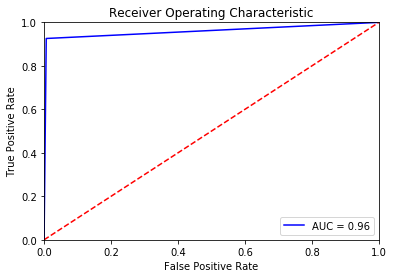

In [66]:
#ROC Curve usinf RandomForest Boosting
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_boosting)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [67]:
#Using SVM-RBF kernel
from sklearn import svm
clf_svm = svm.SVC(kernel = 'rbf')
clf_svm.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [68]:
y_pred_svm = clf_svm.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report,recall_score, precision_score, f1_score
print(classification_report(y_test, y_pred_svm))
print("accuracy:", accuracy_score(y_test, y_pred_svm))
print("pecision:", precision_score(y_test, y_pred_svm))
print("recall:", recall_score(y_test, y_pred_svm)) 
print("f1 score:", f1_score(y_test, y_pred_svm)) 

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2631
           1       0.86      0.80      0.83       526

   micro avg       0.95      0.95      0.95      3157
   macro avg       0.91      0.89      0.90      3157
weighted avg       0.94      0.95      0.94      3157

accuracy: 0.9455178967374089
pecision: 0.8627049180327869
recall: 0.8003802281368821
f1 score: 0.8303747534516767


In [69]:
#Quadratic Discriminant Analysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf_qda = QuadraticDiscriminantAnalysis()
clf_qda.fit(X_train,y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [70]:
y_pred_qda = clf_qda.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report,recall_score, precision_score, f1_score
print(classification_report(y_test, y_pred_qda))
print("accuracy:", accuracy_score(y_test, y_pred_qda))
print("pecision:", precision_score(y_test, y_pred_qda))
print("recall:", recall_score(y_test, y_pred_qda)) 
print("f1 score:", f1_score(y_test, y_pred_qda)) 

              precision    recall  f1-score   support

           0       0.84      0.98      0.91      2631
           1       0.50      0.09      0.15       526

   micro avg       0.83      0.83      0.83      3157
   macro avg       0.67      0.54      0.53      3157
weighted avg       0.79      0.83      0.78      3157

accuracy: 0.8333861260690529
pecision: 0.5
recall: 0.08935361216730038
f1 score: 0.15161290322580645


## RNN

In [0]:
# Set RNN parameters
epochs = 10
batch_size = 60
max_features = 15000
maxlen = 500

In [0]:
text_data = list(df_upsam["reviewText"])
text_label =  list(df_upsam["labels"])

In [75]:
print(len(text_data))
print(len(text_label))

9564
9564


In [0]:
import re

def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return text_string


# Clean texts
text_data = [clean_text(x) for x in text_data]



In [78]:
from keras.layers import SimpleRNN, Embedding, Dense, LSTM
from keras.models import Sequential

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# number of words used as features
max_features = 15000
# cut off the words after seeing 500 words in each review.
maxlen = 500

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)

word_index = tokenizer.word_index
print("Found {0} unique words: ".format(len(word_index)))

data = pad_sequences(sequences, maxlen=maxlen)

print("data shape: ", data.shape)

#np.random.seed(42)

Using TensorFlow backend.


Found 14471 unique words: 
data shape:  (9564, 500)


In [0]:
x_train_rnn, x_test_rnn, y_train_rnn, y_test_rnn = train_test_split(data, text_label, test_size=0.33, random_state=np.random.RandomState(), stratify = text_label)

In [80]:

models = Sequential()
models.add(Embedding(max_features, 32))
models.add(SimpleRNN(32))
models.add(Dense(1, activation='sigmoid'))

models.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history_rnn_new = models.fit(x_train_rnn, y_train_rnn, epochs=10, batch_size=60, validation_split=0.2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 5125 samples, validate on 1282 samples
Epoch 1/10
5125/5125 [==============================] - 8s 2ms/step - loss: 0.4928 - acc: 0.8070 - val_loss: 0.4260 - val_acc: 0.8331
Epoch 2/10
5125/5125 [==============================] - 7s 1ms/step - loss: 0.2909 - acc: 0.8878 - val_loss: 0.2331 - val_acc: 0.9275
Epoch 3/10
5125/5125 [==============================] - 7s 1ms/step - loss: 0.1246 - acc: 0.9618 - val_loss: 0.1427 - val_acc: 0.9509
Epoch 4/10
5125/5125 [==============================] - 8s 1ms/step - loss: 0.0618 - acc: 0.9832 - val_loss: 0.0968 - val_acc: 0.9719
Epoch 5/10
5125/5125 [==============================] - 7s 1ms/step - loss: 0.0407 - acc: 0.9887 - val_loss: 0.0930 - val_acc: 0.9704
Epoch 6/10
5125/5125 [==============================] - 7s 1ms/step - loss: 0.0228 - acc: 0.9943 - val_loss: 0.0754 - val_acc: 0.9766
Epoch 7/10
5125/5125 [======

In [81]:
pred = models.predict_classes(x_test_rnn)
acc = models.evaluate(x_test_rnn, y_test_rnn)
proba_rnn = models.predict_proba(x_test_rnn)
from sklearn.metrics import confusion_matrix
print("Test loss is {0:.2f} accuracy is {1:.2f}  ".format(acc[0],acc[1]))
print(confusion_matrix(pred, y_test_rnn))

3157/3157 [==============================] - 2s 505us/step
Test loss is 0.07 accuracy is 0.98  
[[2603   34]
 [  28  492]]


In [82]:
from sklearn.metrics import accuracy_score, classification_report,recall_score, precision_score
print(classification_report(y_test_rnn, pred))
print("accuracy:", accuracy_score(y_test_rnn, pred))
print("pecision:", precision_score(y_test_rnn, pred))
print("recall:", recall_score(y_test_rnn, pred)) 
print("f1 score:", f1_score(y_test_rnn, pred)) 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2631
           1       0.95      0.94      0.94       526

   micro avg       0.98      0.98      0.98      3157
   macro avg       0.97      0.96      0.96      3157
weighted avg       0.98      0.98      0.98      3157

accuracy: 0.9803611023123219
pecision: 0.9461538461538461
recall: 0.935361216730038
f1 score: 0.9407265774378585
